# Binary classificator for pertinent sentences
Built with Keras and Tensorflow

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import tensorflow as tf
import keras
import sklearn
import transformers
import datasets
from datasets import load_dataset
from keras import models, layers, metrics
from transformers import AutoTokenizer, TFBertModel

## Dataset Import
The dataset are already splitted and provided in Hugging Face format. It could be imported with:

In [2]:
data_files = {
	"train": "data/detection-ds-train.parquet",
	"valid": "data/detection-ds-valid.parquet",
	"test": "data/detection-ds-test.parquet"
}

ds = load_dataset("parquet", data_files=data_files)
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3031
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 649
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 650
    })
})

## Model Building
The checkpoint is bert-base-uncased


In [3]:
# Get BERT layer
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
bert_tf= TFBertModel.from_pretrained(checkpoint, trainable=False)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [4]:
def tokenize (batch):
    return tokenizer(batch["text"], max_length=512, padding='max_length', truncation=True, return_tensors="tf")

ds_encoded = ds.map(tokenize, batched= True, batch_size= None)
print(ds_encoded["train"].column_names)

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


In [5]:
# Training predictors
X_tf_train = [tokenizer(text, padding="max_length",max_length = 512, truncation=True)['input_ids'] for text in ds_encoded["train"]['text']]
X_tf_train = np.array(X_tf_train, dtype='int32')

# Validation predictors
X_tf_valid = [tokenizer(text, padding="max_length",max_length = 512, truncation=True)['input_ids'] for text in ds_encoded["valid"]['text']]
X_tf_valid = np.array(X_tf_valid, dtype='int32')

In [6]:
# Training target
y_tf_train = ds_encoded["train"]["label"]
y_tf_train = np.array(y_tf_train)

# Validation target
y_tf_valid = ds_encoded["valid"]["label"]
y_tf_valid = np.array(y_tf_valid)

Utilizzeremo a dispetto del precedente Notebook i tensori dati dagli array NumPy e quindi non quelli di Tensorflow. Questa è una feature di tensorflow che Pytorch non possiede.
La prima cosa da fare dunque è quella di convertire gli input in Array NumPy utilizzando il tokenizer

## Costruzione del modello

In [7]:
# Metrics to monitor during training
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

# Model layers
input_ids_in = layers.Input(shape=(512,), name='input_token', dtype='int32')

x = bert_tf(input_ids=input_ids_in)[0][:,0,:]
x = layers.Dropout(0.3, name='dropout')(x)
x = layers.Dense(768, activation='relu', name='pre-classifier')(x)
x = layers.Dense(1, activation='sigmoid', name='classification')(x)

# Model construction
model_tf = models.Model(inputs=input_ids_in, outputs = x, name='BinaryClassificator')

model_tf.compile(loss="binary_crossentropy", optimizer="adam",metrics=METRICS)
model_tf.summary()


Model: "BinaryClassificator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 512)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             512, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                               

# Model visualization

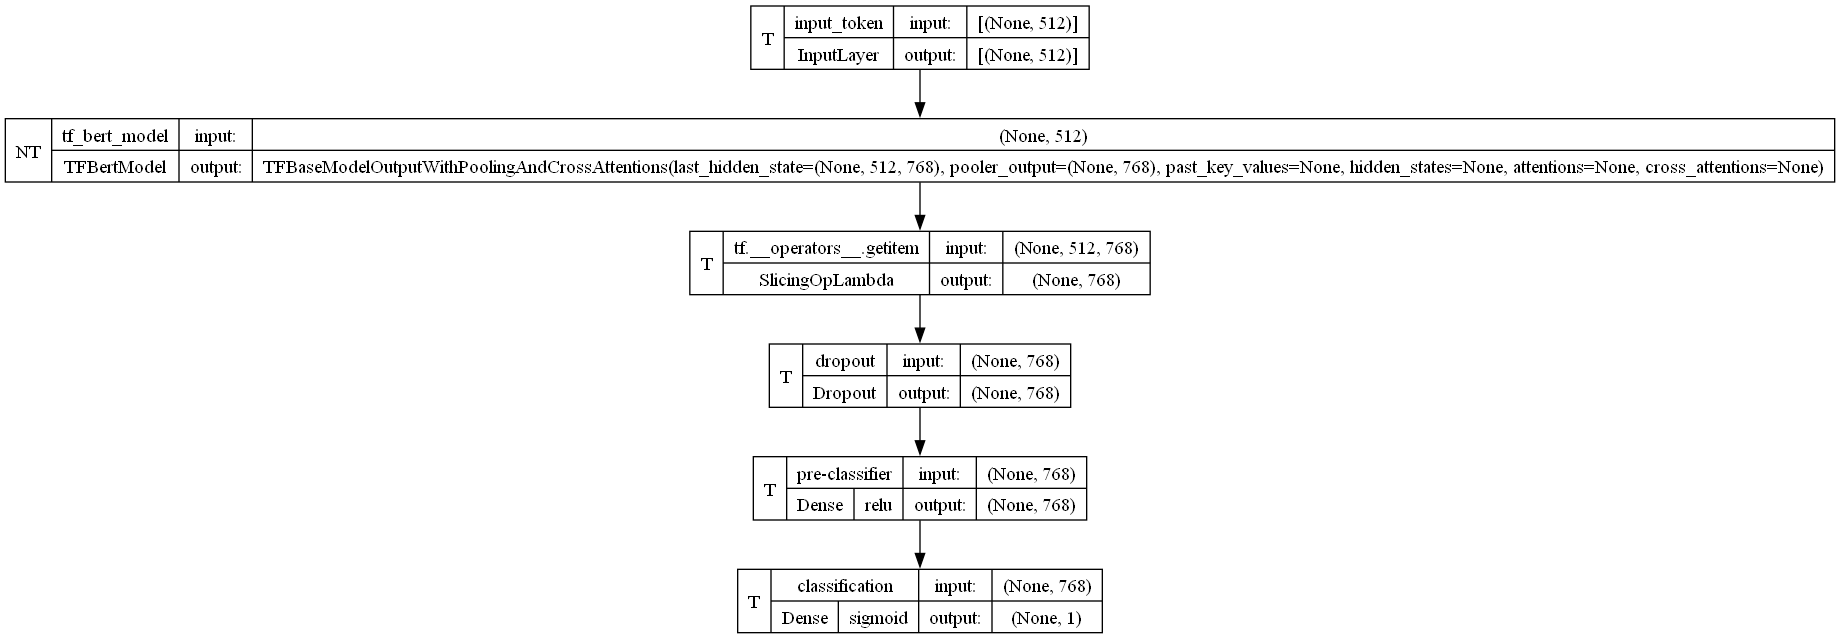

In [8]:
tf.keras.utils.plot_model(
    model_tf,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    show_layer_activations=True,
    show_trainable=True,
)

# Training

In [9]:
history = model_tf.fit(X_tf_train, y_tf_train, batch_size=32, shuffle=True, epochs=10, validation_data=(X_tf_valid, y_tf_valid))

history_df  = pd.DataFrame(history.history)

Epoch 1/10
95/95 [==============================] - 2311s 24s/step - loss: 0.6096 - accuracy: 0.6645 - precision: 0.6535 - recall: 0.6785 - val_loss: 0.4892 - val_accuracy: 0.6502 - val_precision: 0.5928 - val_recall: 0.9970
Epoch 2/10
95/95 [==============================] - 2321s 24s/step - loss: 0.5209 - accuracy: 0.7334 - precision: 0.7205 - recall: 0.7495 - val_loss: 0.3357 - val_accuracy: 0.8968 - val_precision: 0.8363 - val_recall: 0.9909
Epoch 3/10
95/95 [==============================] - 2312s 24s/step - loss: 0.5132 - accuracy: 0.7377 - precision: 0.7263 - recall: 0.7502 - val_loss: 0.3185 - val_accuracy: 0.8783 - val_precision: 0.9772 - val_recall: 0.7788
Epoch 4/10
95/95 [==============================] - 2315s 24s/step - loss: 0.5049 - accuracy: 0.7367 - precision: 0.7258 - recall: 0.7482 - val_loss: 0.5625 - val_accuracy: 0.6918 - val_precision: 1.0000 - val_recall: 0.3939
Epoch 5/10
95/95 [==============================] - 2309s 24s/step - loss: 0.4775 - accuracy: 0.7605

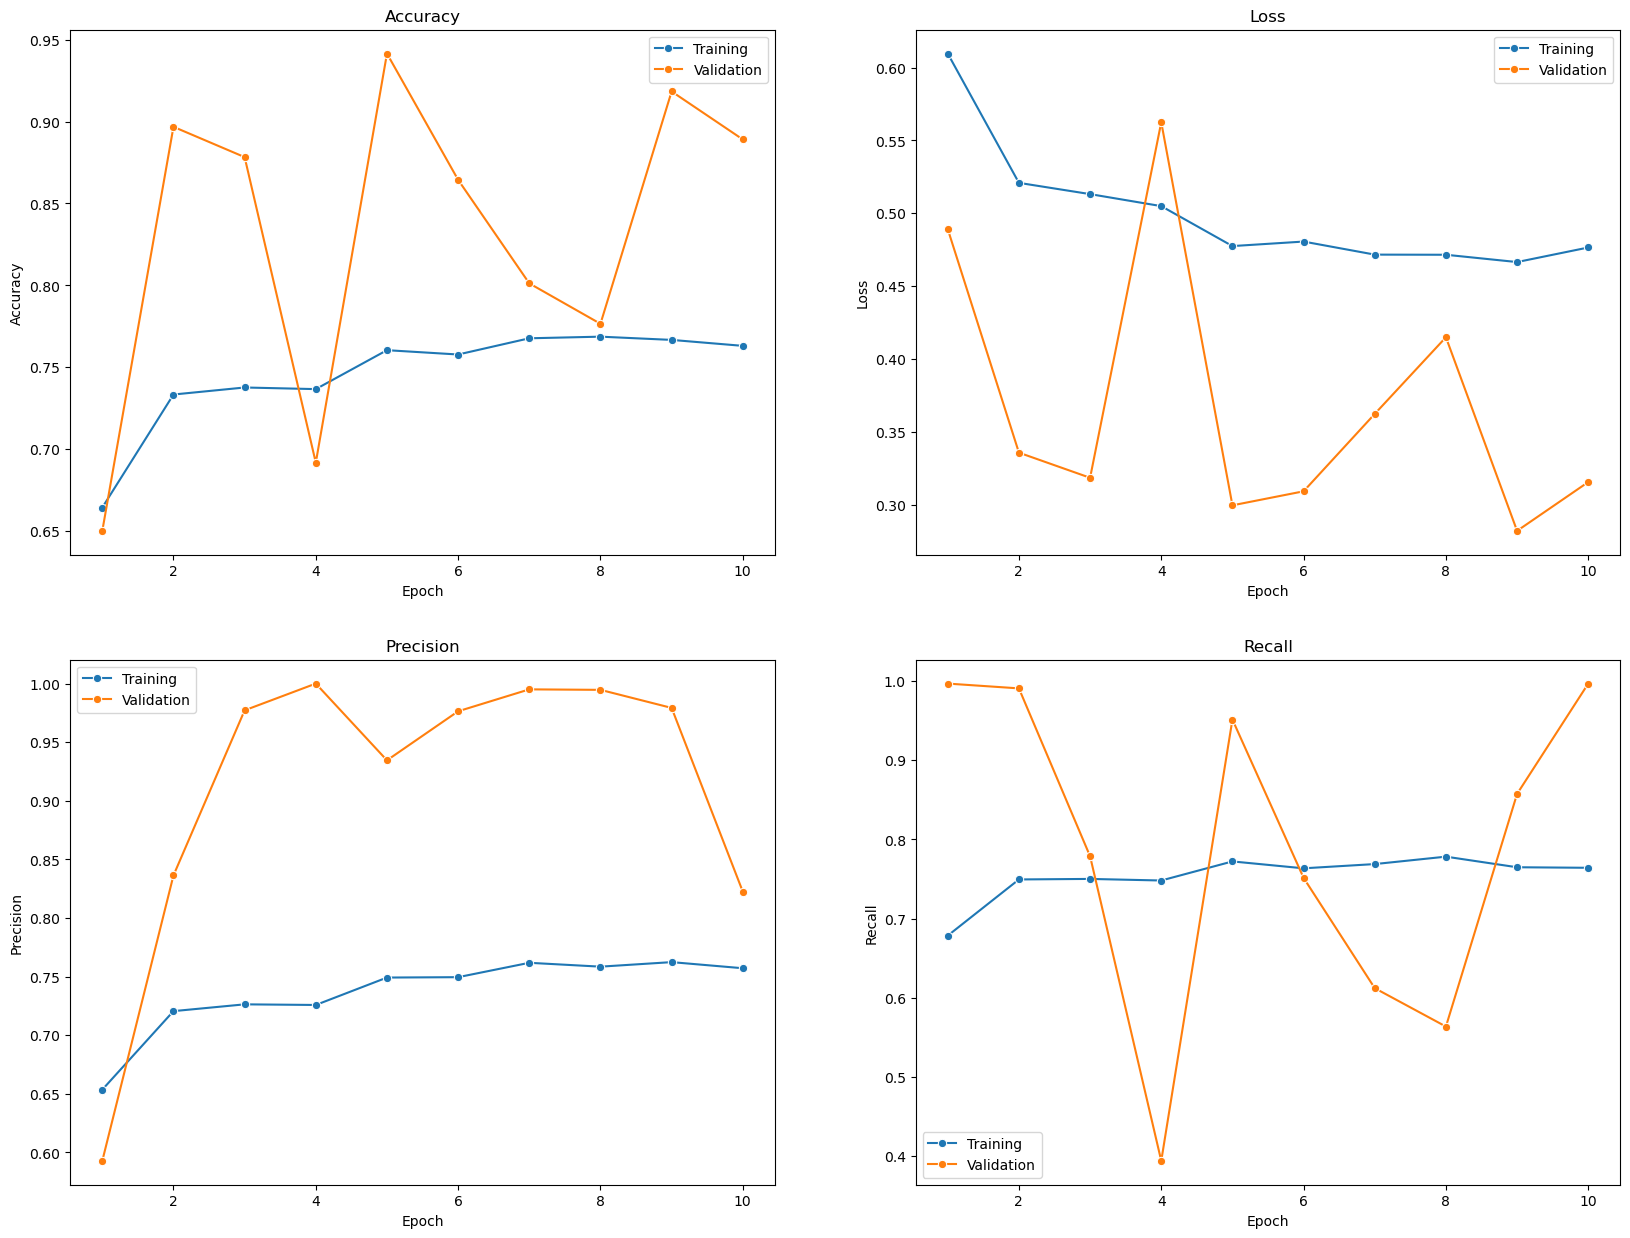

In [11]:
# METRICS PLOTTING

fig, axes = plt.subplots(2, 2, figsize = (20,15))

# Accuracy plots
sns.lineplot(data = history_df, x = range(1,11), y = 'accuracy', marker = 'o', label = 'Training', ax = axes[0, 0])
sns.lineplot(data = history_df, x = range(1,11), y = 'val_accuracy', marker = 'o', label = 'Validation', ax = axes[0, 0])
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Loss plots
sns.lineplot(data = history_df, x = range(1,11), y = 'loss', marker = 'o', label = 'Training', ax = axes[0, 1])
sns.lineplot(data = history_df, x = range(1,11), y = 'val_loss', marker = 'o', label = 'Validation', ax = axes[0, 1])
axes[0, 1].set_title('Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# Precision plots
sns.lineplot(data = history_df, x = range(1,11), y = 'precision', marker = 'o', label = 'Training', ax = axes[1, 0])
sns.lineplot(data = history_df, x = range(1,11), y = 'val_precision', marker = 'o', label = 'Validation', ax = axes[1, 0])
axes[1, 0].set_title('Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()

# Recall plots
sns.lineplot(data = history_df, x = range(1,11), y = 'recall', marker = 'o', label = 'Training', ax = axes[1, 1])
sns.lineplot(data = history_df, x = range(1,11), y = 'val_recall', marker = 'o', label = 'Validation', ax = axes[1, 1])
axes[1, 1].set_title('Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()


plt.show()

21/21 [==============================] - 332s 16s/step


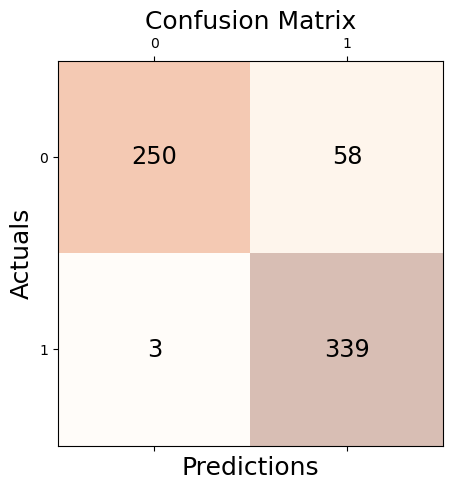

In [12]:
from sklearn.metrics import confusion_matrix

predictions = model_tf.predict(ds_encoded['test']['input_ids'])
y_pred_binary = np.round(predictions, 0)

# Plotting confusion matrix
result = confusion_matrix(ds_encoded['test']['label'], y_pred_binary )

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(result, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        ax.text(x=j, y=i,s=result[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [15]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

print("Metrics on test dataset:")
print("precision: \t", np.round(precision_score(ds_encoded['test']['label'], y_pred_binary)*100, 2))
print("recall: \t", np.round(recall_score(ds_encoded['test']['label'], y_pred_binary)*100, 2))
print("accuracy: \t", np.round(accuracy_score(ds_encoded['test']['label'], y_pred_binary)*100, 2))
print("f1-score: \t", np.round(f1_score(ds_encoded['test']['label'], y_pred_binary)*100, 2))

Metrics on test dataset:
precision: 	 85.39
recall: 	 99.12
accuracy: 	 90.62
f1-score: 	 91.75


In [16]:
model_tf.save('output/detector-bert.keras')

## Model Usage


### Loading_model

In [14]:
my_reloaded_model = tf.keras.models.load_model(
       'output/detector-bert.keras',
       custom_objects={"TFBertModel": transformers.TFBertModel}
)

In [20]:
from datasets import Dataset, DatasetDict

# Import the scraped document
path = r'C:\Users\gltut\Desktop\Corsi\Data Security\Project\HTML_Scraper\data\wizardspider.csv'
df = pd.read_csv(path)
df = df.drop('Unnamed: 0', axis = 1)


checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize (batch):
    return tokenizer(batch["text"], max_length=512, padding='max_length', truncation=True, return_tensors="tf")

# Convert the DataFrame to a datasets.Dataset
dataset = Dataset.from_pandas(df)

# Create a DatasetDict with a single dataset
dataset_dict = DatasetDict({'my_dataset': dataset})
ds_encoded = dataset_dict.map(tokenize, batched= True, batch_size= None)

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

In [21]:
# Tokenization
X = [tokenizer(text, padding="max_length",max_length = 512, truncation=True)['input_ids'] for text in ds_encoded["my_dataset"]['text']]
X = np.array(X, dtype='int32')


In [22]:
df_final = pd.DataFrame(data = dataset['text'], columns = ['text'])

def confidence_col(num: float):
    if num <= 0.5:
        return np.round(1 - num,4)
    else:
        return np.round(num,4)

def detection_col(num:float):
    return np.round(num, 0)


prediction_sample= my_reloaded_model.predict(X)

# Building the final detection dataset
df_final['prediction'] = prediction_sample
df_final['detection'] = df_final['prediction'].apply(detection_col)
df_final['confidence'] = df_final['prediction'].apply(confidence_col)
df_final = df_final.drop('prediction', axis = 1)
df_final

2/2 [==============================] - 24s 9s/step


,text,detection,confidence
0,Trickbot Adds Credential-Grabbing Capabilities...,0.0,0.7257
1,Respond Faster.,1.0,0.6820
2,See More.,1.0,0.7959
3,Respond Faster.,1.0,0.6820
4,Move faster than your adversaries with powerfu...,1.0,0.6758
5,Respond to Threats AgilelyMaximize effectivene...,0.0,0.5714
6,Learn moreXDR for OTXDR for OTStop adversaries...,0.0,0.9589
7,Under Attack?,1.0,0.7660
8,6 AlertsBackUnreadAllTrend helps shield the wo...,1.0,0.7880
9,Threat Encyclopedia\t\t\t\t\tCloud Health Asse...,1.0,0.9822


In [23]:
df_final.to_csv('output/wizardspider_detection.csv')